<h1 align="center">  Credit risk project</h1> <br>
<img src="lendclub.png"><br><br>



Lending club has a simple set of rules for determining risky loans 

Want to be better at determining the risk of a loan, and grade it more approprately

The CEO has heard of ML


In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1920,
        'height': 768,
        'scroll': True,
})

{'width': 1920, 'height': 768, 'scroll': True}

### Task

Based on the information we have **at the time of loan application**, build a Machine Learning model that **classifies** of the loan will be paid back in time or not. 

The model will replace the old model and be used to calculate interest rate, grading and potential manual processing


### Outline of the project

Data filtering and feature selection

Data visualization

Prepare data for modeling

Modeling
* Linear model etc
* Boosting models

* Enrich with NLP

"Putting it into production" 


<h1 align="center"> Lending Club Loan ML project </h1> <br>


## Company Information - Lending Club 
peer to peer loans (consumer to consumer)



<img src="http://echeck.org/wp-content/uploads/2016/12/Showing-how-the-lending-club-works-and-makes-money-1.png"><br><br>

Lending Club is a  peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take (the borrowers credit score). Lending Club provides the "bridge" between investors and borrowers. For more basic information about the company please check out the wikipedia article about the company. <br><br>





In [2]:
!pip install pandas scikit-learn seaborn matplotlib nltk lightgbm xgboost shap RISE imblearn



## Data preparation and visualization
* Ingest data, and remove unwanted columns from data
* Create label for binary classifcation
* Visualize data 



# Import libraries

In [3]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle


%matplotlib inline

<img src="data2.png"><br><br>

# Read data


* type: CSV
* size 450 MB
* rows: 887000
* potential fetures: 75



In [4]:
#parse csv
df = pd.read_csv('loan.csv', low_memory=False)

#show data
print(f"Data has {df.shape[0]} rows")
df.head() 

Data has 887379 rows


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

# filter data

<img src="columns2.png"><br><br>

In [6]:
cols = pd.read_csv("Data_desc.csv") # Read in column definition csv

column_definition = cols.loc[cols["Keep"] == 'Yes'] # only keep chosen columns 

# list all numeric columns
numeric_cols = (column_definition["Column name"]
                [column_definition["Type"]=="Numeric"]) 

# list all categorical columns
categorical_cols = (column_definition["Column name"]
                    [column_definition["Type"]=="Categorical"]) 
# list all text columns
text_cols = (column_definition["Column name"]
             [column_definition["Type"]=="Text"]) 

# filter dataframe to only include chosen columns
start_data = df[column_definition["Column name"]] 

#filter data to only include individual applications 
start_data = start_data[start_data["application_type"] == "INDIVIDUAL"].copy()

# drop unnecessary column
start_data.drop(columns=["application_type"], inplace=True)



### Show start data

In [7]:
print("""Start data has:
{} rows and 
{} columns""".format(start_data.shape[0],
                     start_data.shape[1]))


start_data.sample(20)


Start data has:
886868 rows and 
16 columns


,id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,addr_state,dti,pub_rec,total_acc
850097,40420894,4000.0,36 months,Receiving,7 years,MORTGAGE,43000.0,Verified,Current,NaN,home_improvement,Home improvement,VA,19.48,0.0,25.0
49458,9775137,19125.0,36 months,NaN,NaN,RENT,49000.0,Verified,Charged Off,NaN,renewable_energy,Green loan,CA,16.53,0.0,6.0
38564,352873,7500.0,36 months,Charles Schwab,10+ years,MORTGAGE,105000.0,Verified,Fully Paid,Have a line of credit with Beneficial that was...,credit_card,Pay Off Beneficial,AZ,10.71,0.0,29.0
61109,8965103,10000.0,36 months,kennel manager,10+ years,MORTGAGE,64000.0,Source Verified,Fully Paid,NaN,debt_consolidation,Debt consolidation,FL,24.62,0.0,24.0
515600,65714527,11200.0,60 months,EDDA,10+ years,MORTGAGE,50000.0,Verified,Current,NaN,debt_consolidation,Debt consolidation,KY,22.20,2.0,27.0
308296,27030234,12500.0,36 months,Cardiac Tech,10+ years,MORTGAGE,62500.0,Not Verified,Current,NaN,home_improvement,Home improvement,GA,19.89,0.0,12.0
883043,38182410,10425.0,36 months,line cook,4 years,MORTGAGE,25000.0,Source Verified,Current,NaN,debt_consolidation,Debt consolidation,FL,10.23,0.0,7.0
864219,39709370,12000.0,36 months,Equipment operator,1 year,RENT,32000.0,Not Verified,Current,NaN,credit_card,Credit card refinancing,CT,20.67,0.0,6.0
733310,50586793,4800.0,36 months,Frac Hand,2 years,RENT,70000.0,Verified,Fully Paid,NaN,home_improvement,Home improvement,MS,20.78,0.0,27.0
141371,4777254,8000.0,36 months,United healthcare,10+ years,MORTGAGE,50000.0,Not Verified,Fully Paid,Borrower added on 05/01/13 > Credit card deb...,debt_consolidation,Cc loan,NV,13.39,0.0,18.0


In [8]:
start_data.head()  

,id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,loan_status,desc,purpose,title,addr_state,dti,pub_rec,total_acc
0,1077501,5000.0,36 months,NaN,10+ years,RENT,24000.0,Verified,Fully Paid,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,AZ,27.65,0.0,9.0
1,1077430,2500.0,60 months,Ryder,< 1 year,RENT,30000.0,Source Verified,Charged Off,Borrower added on 12/22/11 > I plan to use t...,car,bike,GA,1.00,0.0,4.0
2,1077175,2400.0,36 months,NaN,10+ years,RENT,12252.0,Not Verified,Fully Paid,NaN,small_business,real estate business,IL,8.72,0.0,10.0
3,1076863,10000.0,36 months,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Fully Paid,Borrower added on 12/21/11 > to pay for prop...,other,personel,CA,20.00,0.0,37.0
4,1075358,3000.0,60 months,University Medical Group,1 year,RENT,80000.0,Source Verified,Current,Borrower added on 12/21/11 > I plan on combi...,other,Personal,OR,17.94,0.0,38.0


In [9]:
# counts of different loan outcomes 

start_data["loan_status"].value_counts()

Current                                                601338
Fully Paid                                             207722
Charged Off                                             45248
Late (31-120 days)                                      11589
Issued                                                   8396
In Grace Period                                          6250
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

### Determining the loans that are bad from loan_status column

In [10]:


# bad_loan = ["Charged Off", 
#             "Default", 
#             "Does not meet the credit policy. Status:Charged Off", 
#             "In Grace Period", 
#             "Late (16-30 days)", 
#             "Late (31-120 days)"]




In [11]:

bad_loan = ["Default", 
            "In Grace Period", 
            "Late (31-120 days)"] # label value 1

good_loan = ["Fully Paid"] # label value 0

current  = ['Current'] # remove from training data



In [12]:

start_data["bad_loan"] = -1
start_data.loc[start_data["loan_status"].isin(bad_loan), 'bad_loan'] = 1
start_data.loc[start_data["loan_status"].isin(good_loan), 'bad_loan'] = 0
start_data.loc[start_data["loan_status"].isin(current), 'bad_loan'] = np.nan
start_data.drop(columns="loan_status", inplace=True)

training_data = start_data[start_data['bad_loan'] >-1].drop("id", axis=1).reset_index(drop=True)

scoring_data = start_data[start_data['bad_loan'].isnull()].reset_index(drop=True)
ids = scoring_data["id"]
scoring_data.drop(columns="id", inplace=True)
print("Fraction of bad loans is {:f} %".format(100*np.mean(training_data["bad_loan"])))

Fraction of bad loans is 8.403739 %


### Save all open loans for later

In [13]:
scoring_data_dictionary = {"data":scoring_data, 
                "loan_ids":ids}

pickle.dump(scoring_data_dictionary, open("scoring_data.pkl", "wb"))

In [14]:
# Now we have

# Ingested the data 

# Removed columns that cause information leak

# Determined what is a good loan and a bad loan

# constructed the label


### How many null values do we have in the data?

In [15]:
training_data.isna().sum()

loan_amnt                   0
term                        0
emp_title               11630
emp_length               8399
home_ownership              0
annual_inc                  0
verification_status         0
desc                   151884
purpose                     0
title                      11
addr_state                  0
dti                         0
pub_rec                     0
total_acc                   0
bad_loan                    0
dtype: int64

In [16]:
def fill_nans(df):
    """
    Function to fill all null values 
        numeric columns get a fill value = 0
        non-numeric columns get a fill value = Unknown
    """
    for column in df.columns:
        if column in list(numeric_cols):
            df[column]=df[column].fillna(0)
        else:
            df[column]=df[column].fillna("Unknown")
    return df


In [17]:
training_data = fill_nans(training_data)
training_data.isna().sum()

loan_amnt              0
term                   0
emp_title              0
emp_length             0
home_ownership         0
annual_inc             0
verification_status    0
desc                   0
purpose                0
title                  0
addr_state             0
dti                    0
pub_rec                0
total_acc              0
bad_loan               0
dtype: int64

In [18]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226780 entries, 0 to 226779
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            226780 non-null  float64
 1   term                 226780 non-null  object 
 2   emp_title            226780 non-null  object 
 3   emp_length           226780 non-null  object 
 4   home_ownership       226780 non-null  object 
 5   annual_inc           226780 non-null  float64
 6   verification_status  226780 non-null  object 
 7   desc                 226780 non-null  object 
 8   purpose              226780 non-null  object 
 9   title                226780 non-null  object 
 10  addr_state           226780 non-null  object 
 11  dti                  226780 non-null  float64
 12  pub_rec              226780 non-null  float64
 13  total_acc            226780 non-null  float64
 14  bad_loan             226780 non-null  float64
dtypes: float64(6), ob

# Visualization/exploration

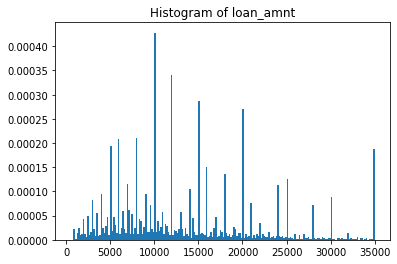

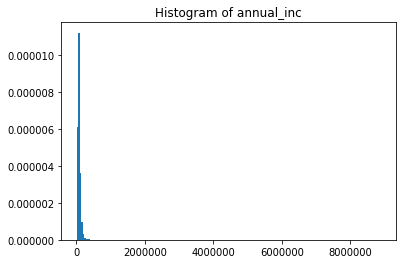

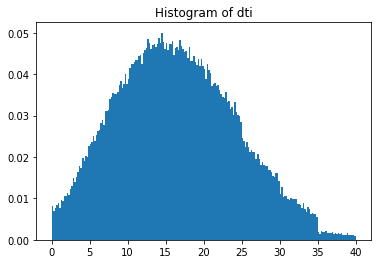

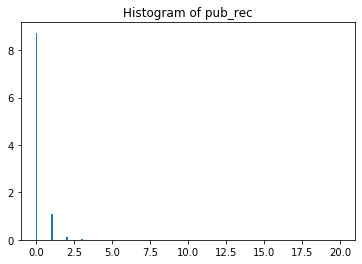

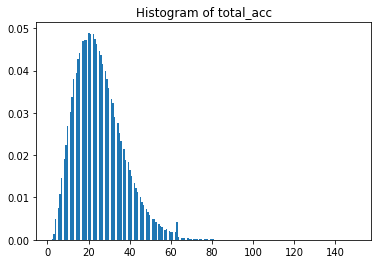

In [19]:
for column in numeric_cols:
    plt.hist(training_data[column], bins=200, density=True, histtype="stepfilled")
    plt.title("Histogram of {}".format(column))
    plt.show()
    
    

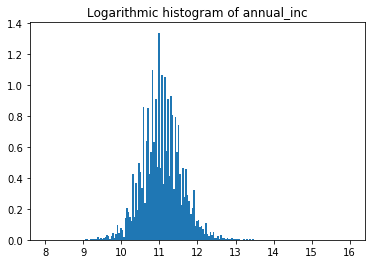

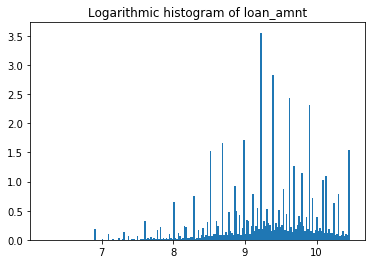

In [20]:
for column in ["annual_inc", "loan_amnt"]:
    plt.hist(np.log(training_data[column]), bins=200, density=True, histtype="stepfilled")
    plt.title("Logarithmic histogram of {}".format(column))
    plt.show()
    

### Correlation plot

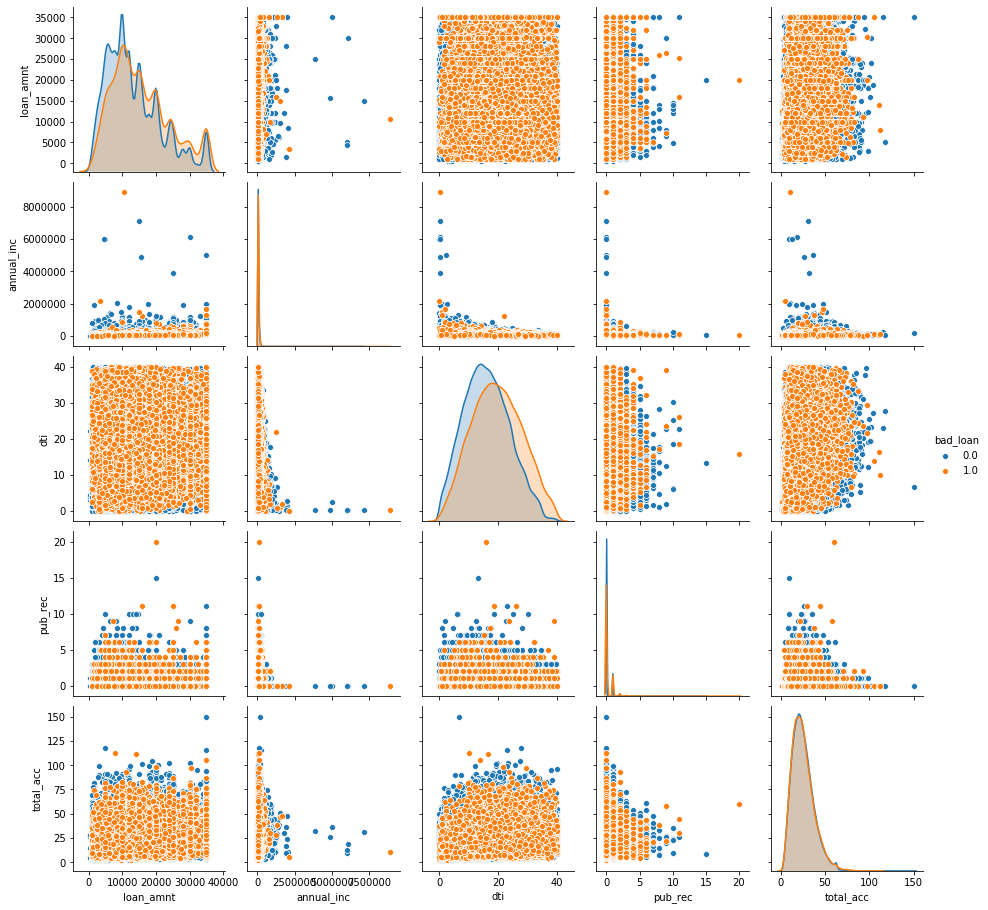

In [21]:
sns.pairplot(training_data, 
             vars=numeric_cols, 
             hue="bad_loan")
plt.show()


### Any differences between differnt categorical values?

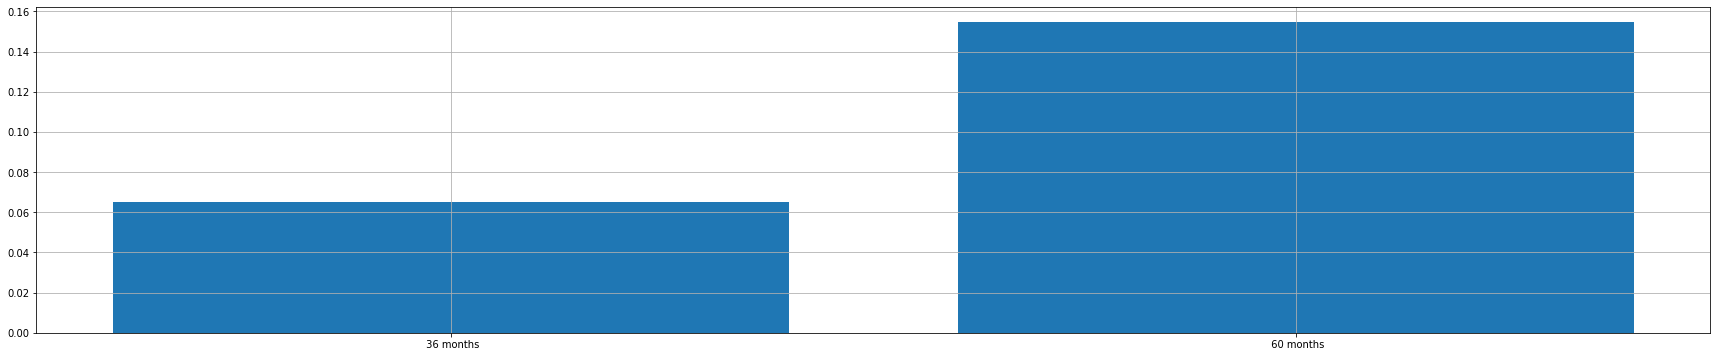

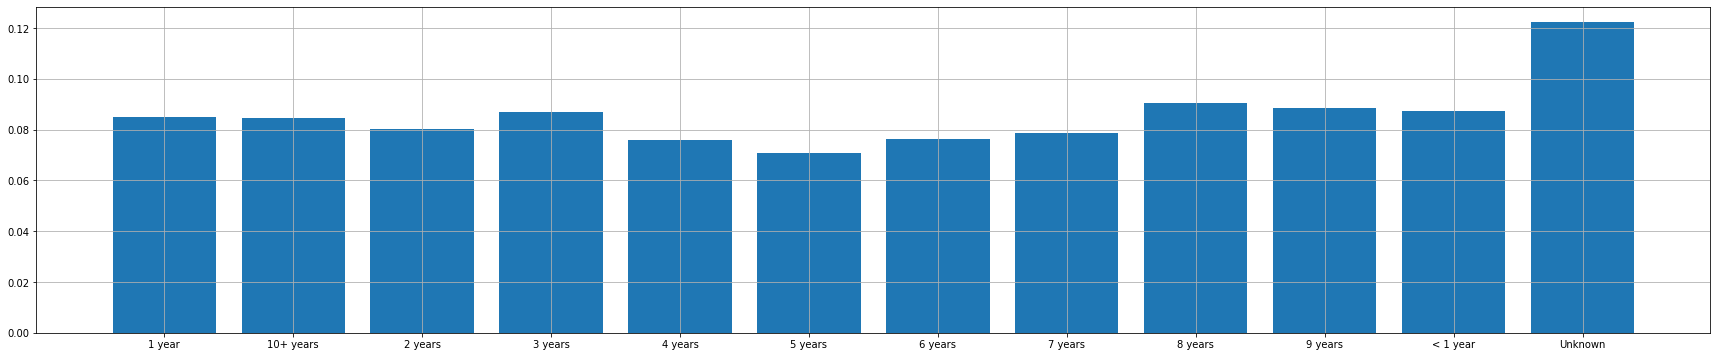

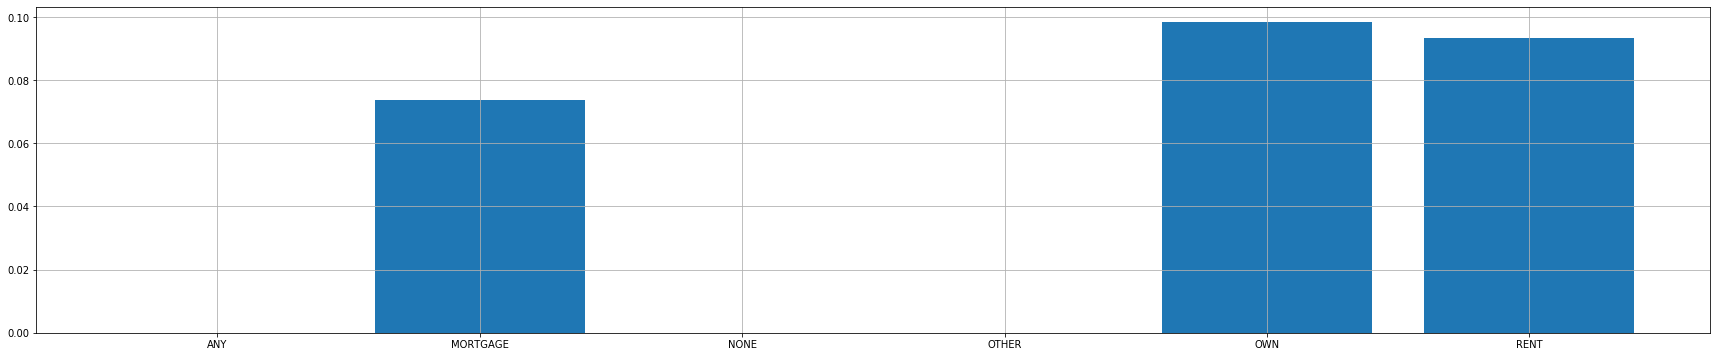

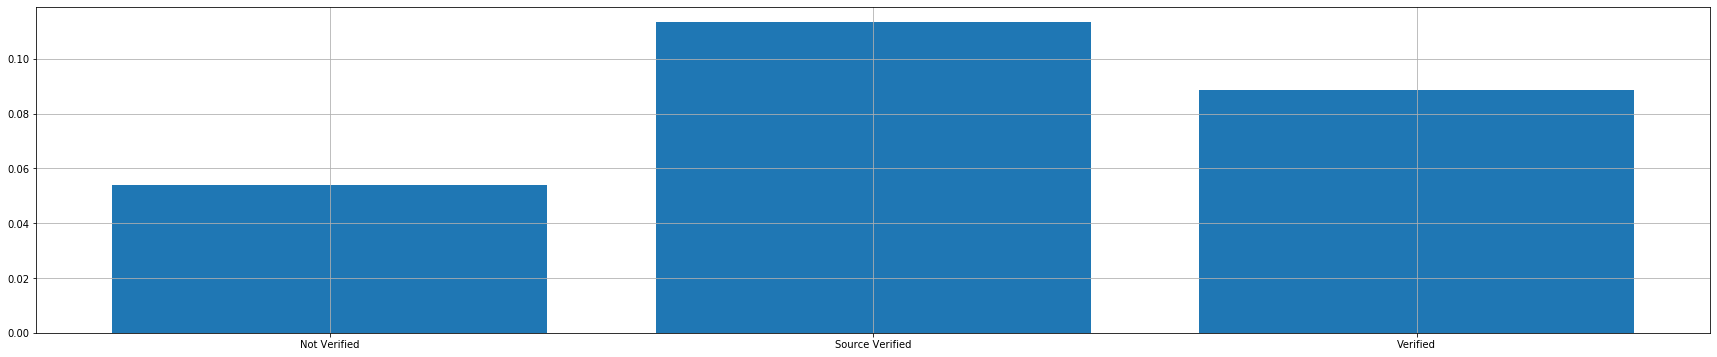

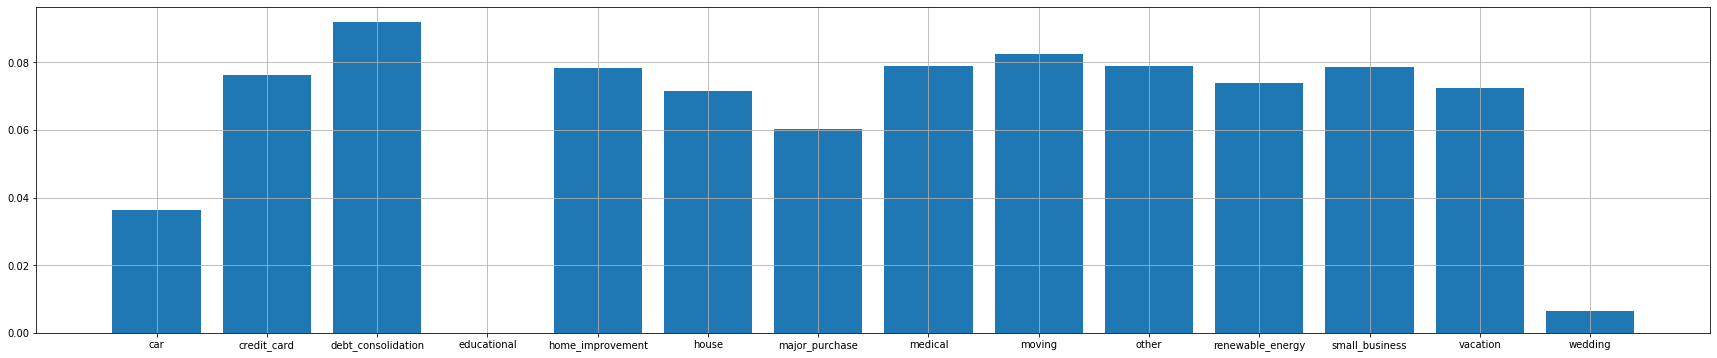

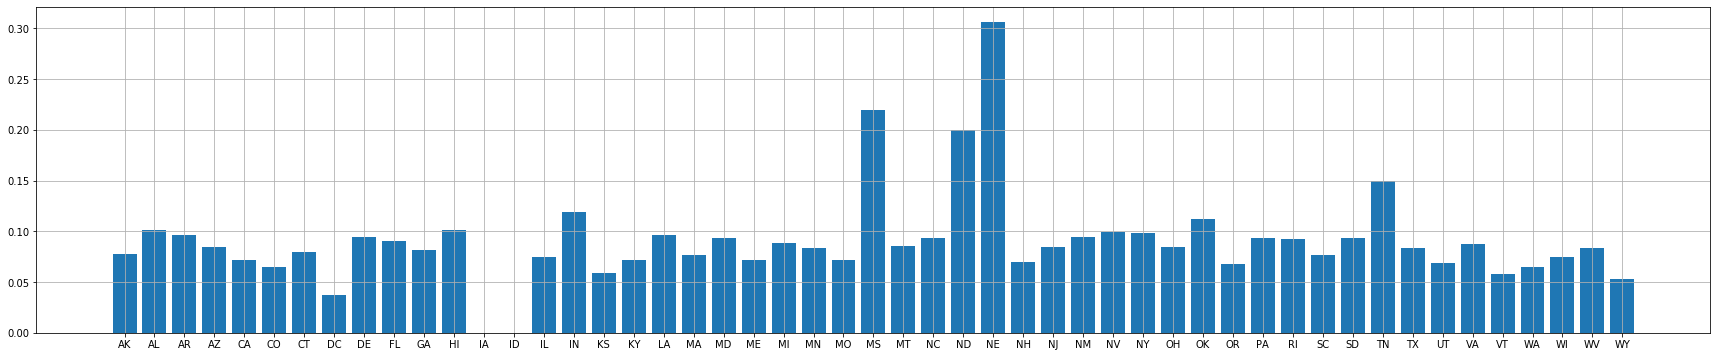

In [22]:

for column in categorical_cols:
    if column in training_data.columns.values:
        fig, ax = plt.subplots(figsize=(30,6))
        tt = training_data.groupby(column).mean()["bad_loan"]
        ax = plt.bar(tt.index, tt.values)
        plt.grid()
        plt.show()
        plt.close()
        
    

## Modeling

### Simple models 
* prepare data for modeling 
* Logistic regression
* Decision tree
* Naive Bayes

### Boosting models 
* xgBoost
* LightGBM

## Adding Text


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn import metrics as mm


def clean_categorical_values(df, rx='[^0-9a-zA-Z]+', rep = "_"):
        df = df.replace(
            rx, rep, regex=True).astype(str)
        return df


class DenseTfidfVectorizer(TfidfVectorizer):

    def transform(self, raw_documents, copy=True, id_str=''):
        X = super().transform(raw_documents, copy=copy)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        df.columns = [id_str + x.replace(' ', '_') for x in df.columns.values]
        return df

    def fit_transform(self, raw_documents, y=None, id_str=''):
        X = super().fit_transform(raw_documents, y=y)
        df = pd.DataFrame(X.toarray(), columns=self.get_feature_names())
        df.columns = [id_str + x.replace(' ', '_') for x in df.columns.values]
        return df
    

def OneHotEncodeDF(df):

    ohe = OneHotEncoder(
        sparse=False, handle_unknown='ignore')
    
    arr_cat_ohe = ohe.fit_transform(df)
   
    cat_ohe_cols = ohe.get_feature_names(
        df.columns.values)
    
    df_cat = pd.DataFrame(arr_cat_ohe, columns=cat_ohe_cols)
    
    return df_cat, ohe

def ScalerDF(df):
    numeric_scaler = StandardScaler()
    np_n = numeric_scaler.fit_transform(df)
    df_n = pd.DataFrame(np_n, columns=df.columns)
    return df_n



def undersample(df, col = "bad_loan", ratio = 1):
    rus = RandomUnderSampler( sampling_strategy=ratio)
    X_rus, y_rus = rus.fit_resample(training_data.drop(col, axis=1), training_data[col])

    X_rus[col] = y_rus
    return X_rus

def precision_recall_curve_with_threshod(y_test, probs, title='title', save=False):
    average_precision = mm.average_precision_score(y_test, probs)
    precision, recall, thresholds = mm.precision_recall_curve(y_test, probs)
    thresholds=np.around(thresholds,decimals=2)
    step_kwargs = {}
    plt.step(recall, precision, color="b",alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)
    idxs=np.linspace(0,len(thresholds)-1,20,dtype=int)
    for idx in idxs:
        plt.scatter(recall[idx],precision[idx],color='r',s=5)
        plt.text(recall[idx],precision[idx],str(thresholds[idx]))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    if title:
        plt.title(title + f' AP={average_precision}')
    
    if save:
        plt.savefig(f'{title}.png',bbox_inches='tight')
    plt.show() 
    


def confusion_matrix_plot(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()



def evaluate_model(model, X, y, title="Model"):
    if ("LogisticRegression" in str(type(model)) or
       "DecisionTreeClassifier" in str(type(model)) or
       "GaussianNB" in str(type(model))):
        
        y_pred=model.predict_proba(X)[:,1]
    else:
        y_pred = model.predict(X)

    print(mm.classification_report(y, np.round(y_pred)))

    fpr, tpr, thresholds = mm.roc_curve(y, y_pred)
    roc_auc = mm.roc_auc_score(y, y_pred)

    plt.title('Receiver Operating Characteristic for {}'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   
    confusion_matrix_plot(y,np.round(y_pred))
    precision_recall_curve_with_threshod(y, y_pred, title=title, save=False)
    
    

# Modeling 

In [24]:
categorical_features = training_data[categorical_cols[categorical_cols.isin(training_data.columns)]]
numeric_features = training_data[numeric_cols[numeric_cols.isin(training_data.columns)]].copy()
categorical_features = clean_categorical_values(categorical_features)
y = training_data["bad_loan"]

### Prepare all features so they are numeric

In [25]:

# Data preparation for linear model
# Categorical features has to be converted to numeric - e.g. OneHot encoding 


categorical_features_ohe, OHE = OneHotEncodeDF(categorical_features)

numeric_features_scaled = ScalerDF(numeric_features)

X = numeric_features_scaled.reset_index(drop=True).merge(
        categorical_features_ohe.reset_index(drop=True), left_index=True, right_index=True)
print("X dimension: {}, y dimension: {}".format(X.shape, y.shape))

X.head()

X dimension: (226780, 93), y dimension: (226780,)


,loan_amnt,annual_inc,dti,pub_rec,total_acc,term__36_months,term__60_months,emp_length_10_years,emp_length_1_year,emp_length_2_years,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,-1.051208,-0.814703,1.433344,-0.331702,-1.372842,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.371133,-1.006258,-0.986509,-0.331702,-1.288221,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.435968,-0.403809,0.455432,-0.331702,0.996536,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.051208,-0.619039,-0.669487,-0.331702,-1.118980,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.297304,-0.423375,-1.417302,-0.331702,-1.795945,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split data & undersampling of training data

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rus = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = rus.fit_resample(X_train, y_train)

## Train and evaluate Linear model 

In [27]:
linear_model = LogisticRegression(max_iter=500)
linear_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       0.95      0.67      0.78     68538
         1.0       0.15      0.63      0.24      6300

    accuracy                           0.66     74838
   macro avg       0.55      0.65      0.51     74838
weighted avg       0.88      0.66      0.74     74838



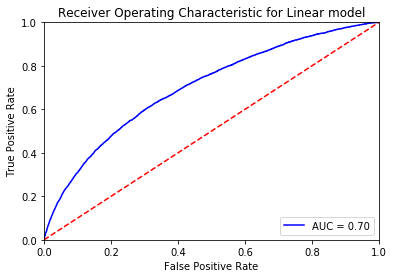

Confusion matrix:
 [[45696 22842]
 [ 2328  3972]]


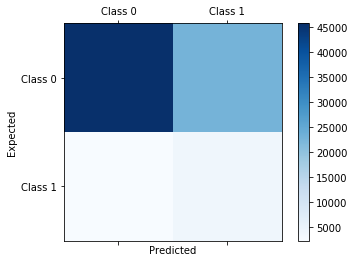

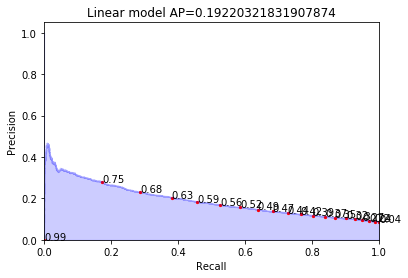

In [28]:
evaluate_model(linear_model, X_test, y_test, "Linear model")


## Decision tree

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
simple_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=1000)

simple_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

         0.0       0.95      0.64      0.77     68538
         1.0       0.14      0.62      0.23      6300

    accuracy                           0.64     74838
   macro avg       0.54      0.63      0.50     74838
weighted avg       0.88      0.64      0.72     74838



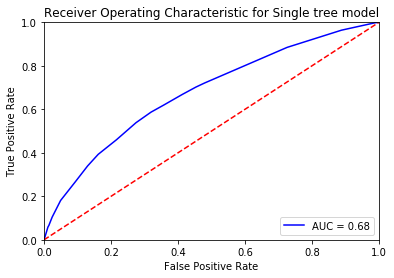

Confusion matrix:
 [[44066 24472]
 [ 2398  3902]]


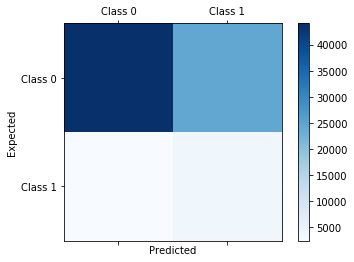

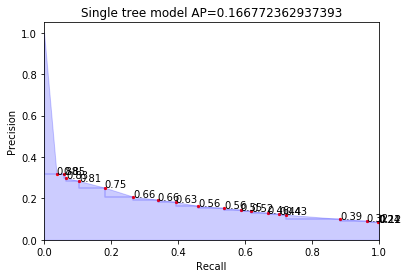

In [30]:
evaluate_model(simple_tree, X_test, y_test, "Single tree model")

### Plot Decision tree

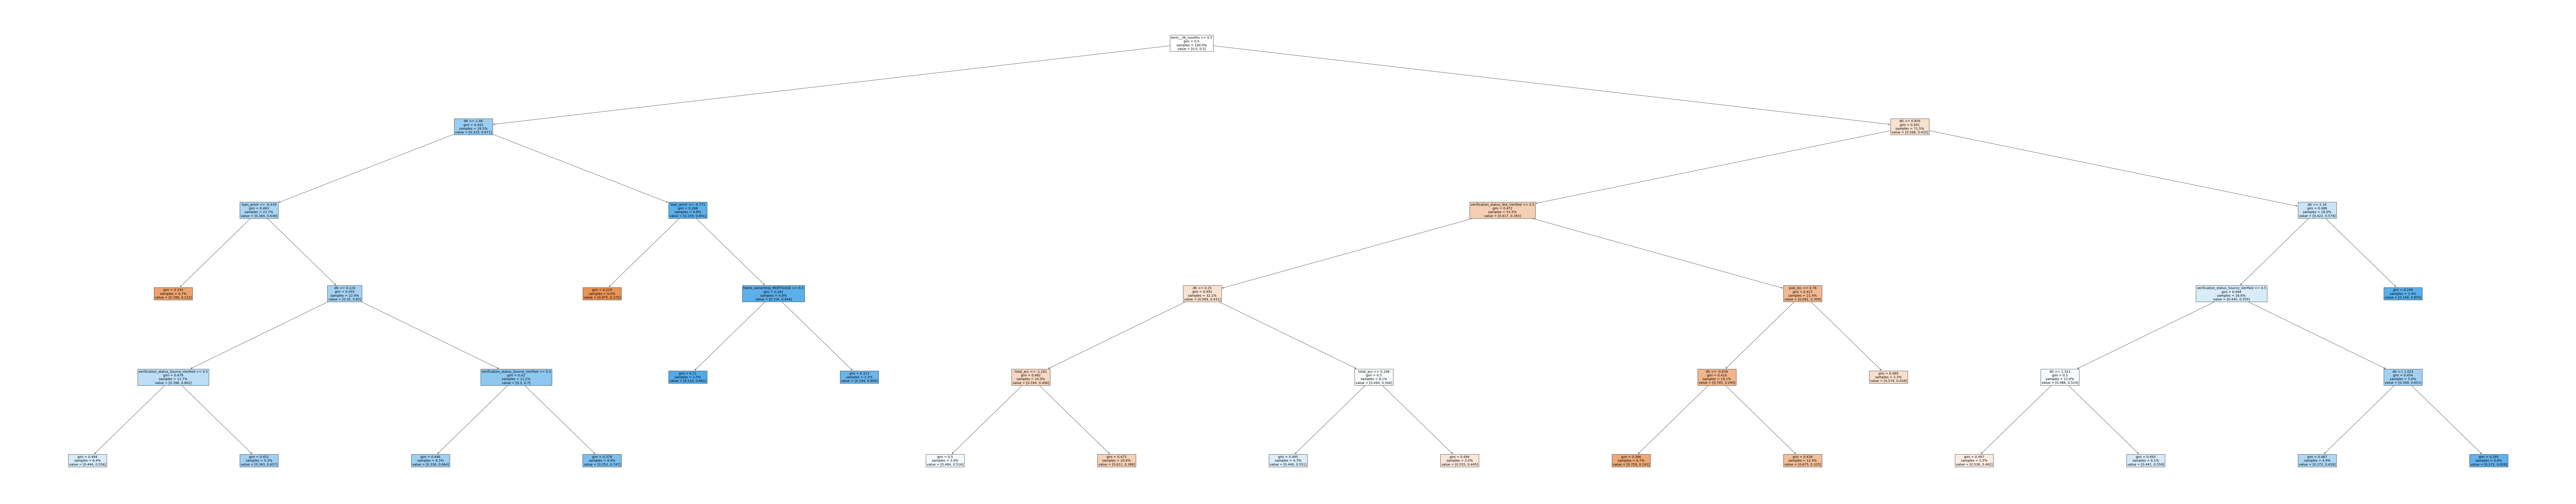

In [31]:
plt.figure(figsize=(200,40))
plt.rcParams['axes.facecolor'] = 'white'
plot_tree(simple_tree, filled=True, feature_names=X_train.columns.values, fontsize=14, proportion=True)
plt.savefig("tree.png", transparent=False)

## Naive bayes 

In [32]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)



GaussianNB(priors=None, var_smoothing=1e-09)

              precision    recall  f1-score   support

         0.0       0.96      0.05      0.09     68538
         1.0       0.09      0.98      0.16      6300

    accuracy                           0.12     74838
   macro avg       0.52      0.51      0.12     74838
weighted avg       0.89      0.12      0.09     74838



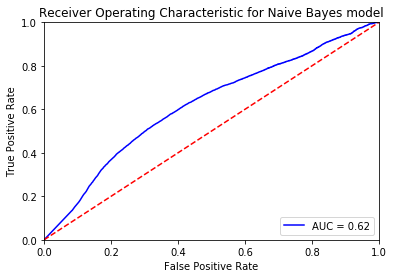

Confusion matrix:
 [[ 3136 65402]
 [  130  6170]]


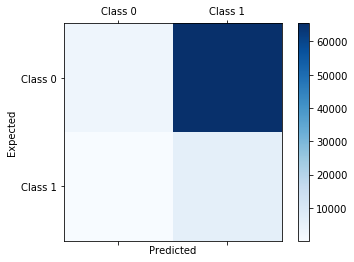

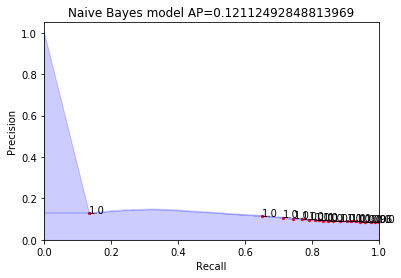

In [33]:
evaluate_model(naive_bayes, X_test, y_test, "Naive Bayes model")

## XGBoost

In [34]:
import xgboost as xgb

params = {"objective":"binary:logistic",
         "eval_metric":"auc",
          "colsample_bytree":0.8}



train_dmatrix = xgb.DMatrix(X_train,
                            label=np.asarray(y_train))

test_dmatrix = xgb.DMatrix(X_test,
                            label=np.asarray(y_test))

xgb_model = xgb.train(params, train_dmatrix,
                      num_boost_round=400,
                      early_stopping_rounds=10,
                      verbose_eval=10,
                      evals=[(train_dmatrix, 'train'),
                             (test_dmatrix, 'test')])

[0]	train-auc:0.697013	test-auc:0.675986
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 10 rounds.
[10]	train-auc:0.744348	test-auc:0.704884
[20]	train-auc:0.76572	test-auc:0.706367
[30]	train-auc:0.777231	test-auc:0.706205
Stopping. Best iteration:
[23]	train-auc:0.769871	test-auc:0.706627



              precision    recall  f1-score   support

         0.0       0.95      0.67      0.79     68538
         1.0       0.15      0.63      0.24      6300

    accuracy                           0.67     74838
   macro avg       0.55      0.65      0.51     74838
weighted avg       0.88      0.67      0.74     74838



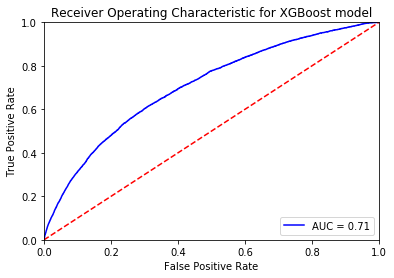

Confusion matrix:
 [[45874 22664]
 [ 2321  3979]]


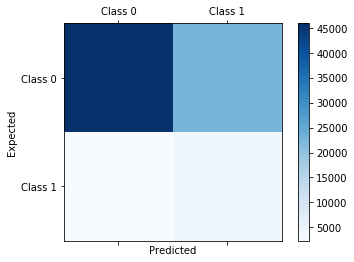

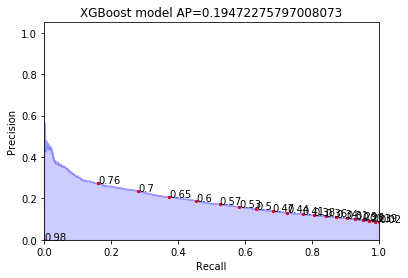

In [35]:
evaluate_model(xgb_model, test_dmatrix, y_test, "XGBoost model")

### xgBoost feature importance

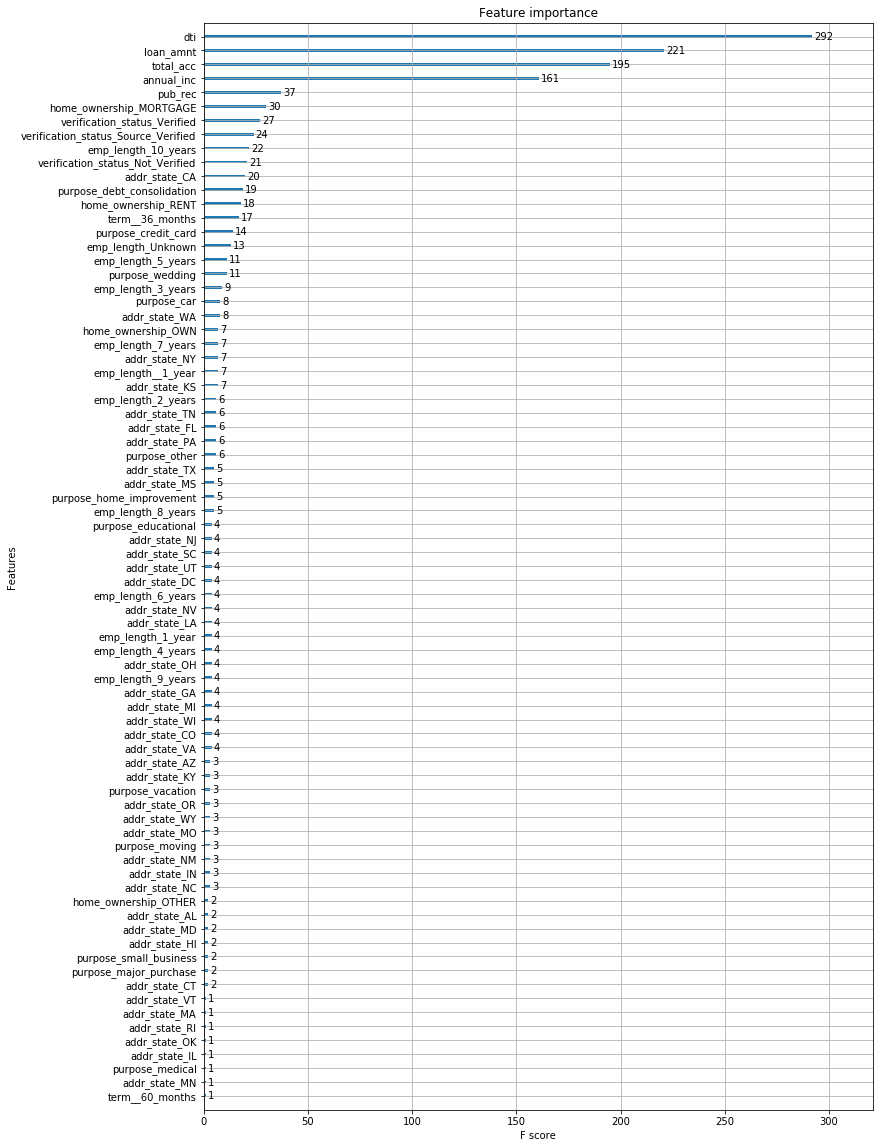

In [36]:
from xgboost import plot_importance
def xgb_importance(booster, figsize, **kwargs):
    """plot xgb importance"""
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
  
xgb_importance(xgb_model, (12,20))

### SHAP values - feature importance for certain cases

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


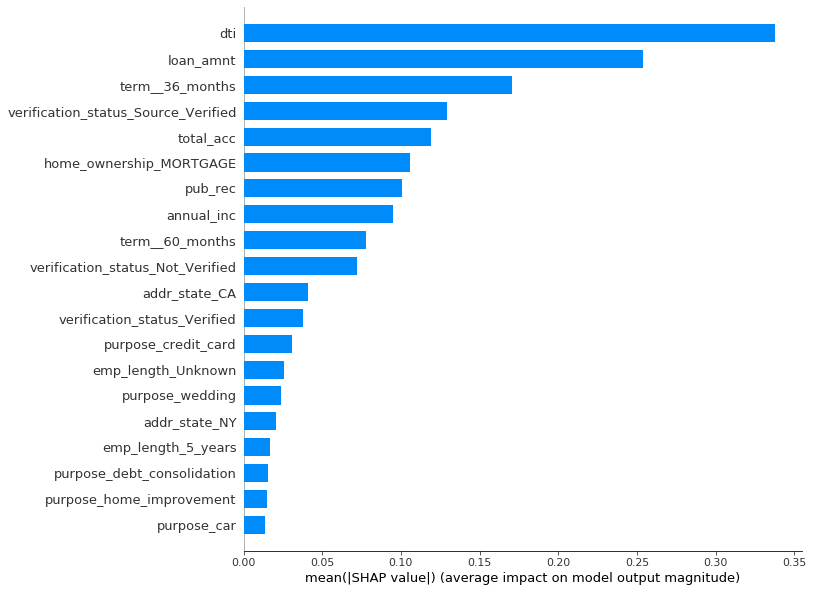

In [37]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,10), max_display=20)

### Prepare data for lightGBM

In [38]:



X = numeric_features.reset_index(drop=True).merge(
        categorical_features.reset_index(drop=True), left_index=True, right_index=True)

X.iloc[:,X.columns.isin(categorical_cols)] = X.iloc[:,X.columns.isin(categorical_cols)].astype("category")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rus = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = rus.fit_resample(X_train, y_train)

X_train.head()

,loan_amnt,annual_inc,dti,pub_rec,total_acc,term,emp_length,home_ownership,verification_status,purpose,addr_state
0,15000.0,51000.0,23.18,0.0,17.0,_60_months,1_year,RENT,Not_Verified,debt_consolidation,NH
1,6000.0,63000.0,29.30,1.0,35.0,_36_months,10_years,RENT,Verified,debt_consolidation,FL
2,13000.0,50600.0,5.19,0.0,23.0,_60_months,10_years,MORTGAGE,Verified,debt_consolidation,WV
3,15000.0,62500.0,18.52,0.0,17.0,_36_months,2_years,RENT,Source_Verified,debt_consolidation,MA
4,15000.0,61000.0,25.83,0.0,22.0,_36_months,_1_year,MORTGAGE,Source_Verified,debt_consolidation,LA


# LightGBM


In [39]:
import lightgbm as lgb
params = {"objective": "binary",
          "learning_rate":0.01,
         "colsample_bytree":0.8,
         "metric": "auc"}
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

lgbmodel = lgb.train(
    params,
    d_train,
    400,
    valid_sets=[d_train, d_test],
    early_stopping_rounds=10,
    verbose_eval=10)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.70937	valid_1's auc: 0.693208
[20]	training's auc: 0.713565	valid_1's auc: 0.695675
[30]	training's auc: 0.7156	valid_1's auc: 0.696392
[40]	training's auc: 0.717903	valid_1's auc: 0.697367
[50]	training's auc: 0.719916	valid_1's auc: 0.698658
[60]	training's auc: 0.721684	valid_1's auc: 0.699643
[70]	training's auc: 0.723414	valid_1's auc: 0.700326
[80]	training's auc: 0.724718	valid_1's auc: 0.700911
[90]	training's auc: 0.726715	valid_1's auc: 0.701611
[100]	training's auc: 0.72834	valid_1's auc: 0.702237
[110]	training's auc: 0.729563	valid_1's auc: 0.702758
[120]	training's auc: 0.731102	valid_1's auc: 0.703221
[130]	training's auc: 0.73226	valid_1's auc: 0.703725
[140]	training's auc: 0.733436	valid_1's auc: 0.70416
[150]	training's auc: 0.734818	valid_1's auc: 0.704618
[160]	training's auc: 0.736066	valid_1's auc: 0.705039
[170]	training's auc: 0.737325	valid_1's auc: 0.705629
[180]	training's au

              precision    recall  f1-score   support

         0.0       0.95      0.67      0.79     68538
         1.0       0.15      0.63      0.24      6300

    accuracy                           0.67     74838
   macro avg       0.55      0.65      0.51     74838
weighted avg       0.88      0.67      0.74     74838



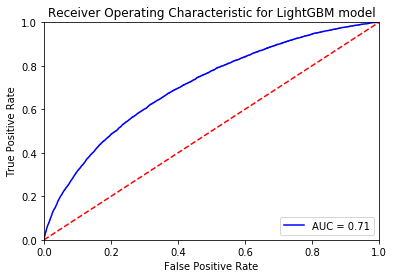

Confusion matrix:
 [[45893 22645]
 [ 2312  3988]]


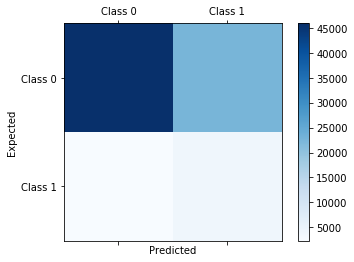

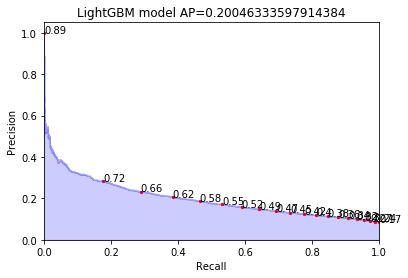

In [40]:
evaluate_model(lgbmodel, X_test, y_test, "LightGBM model")

### SHAP Values for LightGBM

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


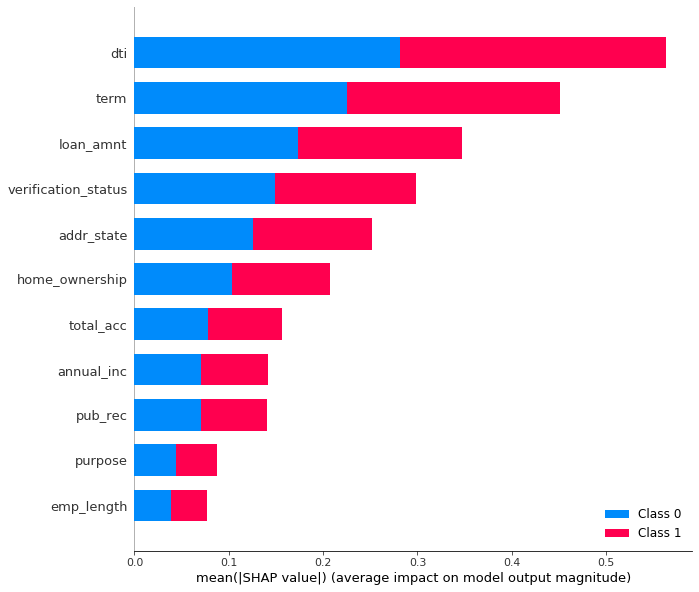

In [41]:
shap.initjs()
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,10), max_display=20)

### Now we have

* tested some diffent models (linear, trees, xgboost, lightgbm)
* we have concluded that a boosing model probably is best 
* looked into what features has the most predictive power

# Adding text data

Including text data can be done in many ways. But the common ground is to convert text to numbers.

In this case we use Term Frequency representation 





    +-------+---------------------+
    |Product| Description         |
    +-------+---------------------+
    |Prod A |Green apple          |
    +-------+---------------------+
    |Prod B |Pink fish            |
    +-------+---------------------+
    |Prod C |Green banana         |
    +-------+---------------------+
                  

                  |
                  v
    
    |Product| green  | apple | pink | fish | banana  |
    +-------+--------+-------+------+------+---------+
    |Prod A |   1    |   1   |  0   |  0   |   0     |
    +-------+--------+-------+------+------+---------+
    |Prod B |   0    |   0   |  1   |  1   |   0     |
    +-------+--------+-------+------+------+---------+
    |Prod C |   1    |   0   |  0   |  0   |   1     |
    +-------+--------+-------+------+------+---------+
             

### Prepare text field, remove common words (=stop words)

In [42]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english') + ["br", "unknown", "added", "borrower"])

textfield_1 = training_data["desc"] + ' ' + training_data["title"]
textfield_2 = training_data["emp_title"]

textfield_1 = clean_categorical_values(textfield_1, rep=' ', rx='[^a-zA-Z]+')
textfield_2 = clean_categorical_values(textfield_2, rep=' ', rx='[^a-zA-Z]+')
stopWords

[nltk_data] Downloading package stopwords to /home/gurra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'added',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'borrower',
 'both',
 'br',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves'

In [43]:
print(textfield_1.sample(20))

117117                           Unknown Debt Consolidation
57358      Borrower added on consolidate my credit cards...
138520                           Unknown Debt consolidation
21141      Borrower added on The purpose of the loan is ...
56509      Borrower added on We want to repay our medica...
222091                      Unknown Credit card refinancing
49072                                        Unknown payoff
129341     Borrower added on I m looking for business st...
117999     Borrower added on Recently moved for a new jo...
124373     Borrower added on The purpose of this loan is...
214790                           Unknown Debt consolidation
114635                           Unknown Debt consolidation
170290                           Unknown Debt consolidation
47841                              Unknown bye credit cards
71965      Borrower added on We are expanding into a new...
15501                                 Unknown PERSONAL LOAN
32585      Borrower added on I have high

In [44]:
print(textfield_2.sample(20))

120909           St Elizabeth Healthcare
13598                   Levi Strauss Co 
18493                      The MathWorks
182646                        Sleep Tech
165468               info specialist III
126112                            Sprint
174247    Executive Assistant to the COO
101135                           Unknown
91966                       Capital Bank
6667                     phi delta theta
130169             BB T Knight Insurance
162599                           Unknown
57920            Army Corps of Engineers
167829                        Supervisor
51977          US Title Guaranty Company
84073         Wonderful Community Church
195501                           Unknown
113475                     Marion County
34304                     Executive Chef
209963     Customer Solutions Consultant
Name: emp_title, dtype: object


In [45]:
tf1 = DenseTfidfVectorizer(max_features=200, max_df=0.3, stop_words=stopWords, 
                          use_idf=False, binary=True, norm=None, ngram_range=(1,5))

df_text1 = tf1.fit_transform(textfield_1, id_str="Description_include_")
tf2 = DenseTfidfVectorizer(max_features=200, max_df=0.3, stop_words=stopWords, 
                          use_idf=False, binary=True, norm=None, ngram_range=(1,5))

df_text2 = tf2.fit_transform(textfield_2, id_str="Job_title_include_")



In [46]:
df_text2.head()

,Job_title_include_account,Job_title_include_account_manager,Job_title_include_accountant,Job_title_include_accounting,Job_title_include_admin,Job_title_include_administration,Job_title_include_administrative,Job_title_include_administrative_assistant,Job_title_include_administrator,Job_title_include_advisor,...,Job_title_include_usa,Job_title_include_valley,Job_title_include_vice,Job_title_include_vice_president,Job_title_include_vp,Job_title_include_warehouse,Job_title_include_wells,Job_title_include_wells_fargo,Job_title_include_worker,Job_title_include_york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
X_new = (X.reset_index(drop=True)
         .merge(df_text1.reset_index(drop=True), 
                left_index=True, right_index=True)
         .merge(df_text2.reset_index(drop=True), 
                left_index=True, right_index=True))

In [48]:
sorted(X_new.columns.values)

['Description_include_able',
 'Description_include_account',
 'Description_include_accounts',
 'Description_include_allow',
 'Description_include_also',
 'Description_include_always',
 'Description_include_amount',
 'Description_include_apr',
 'Description_include_back',
 'Description_include_balance',
 'Description_include_balances',
 'Description_include_bank',
 'Description_include_better',
 'Description_include_bill',
 'Description_include_bills',
 'Description_include_budget',
 'Description_include_business',
 'Description_include_buy',
 'Description_include_car',
 'Description_include_card',
 'Description_include_card_consolidation',
 'Description_include_card_debt',
 'Description_include_card_payoff',
 'Description_include_card_refinance',
 'Description_include_card_refinancing',
 'Description_include_cards',
 'Description_include_cash',
 'Description_include_cc',
 'Description_include_club',
 'Description_include_college',
 'Description_include_company',
 'Description_include_consideration',
 'Description_include_consolidate',
 'Description_include_consolidate_credit',
 'Description_include_consolidate_credit_card',
 'Description_include_consolidate_credit_card_debt',
 'Description_include_consolidate_credit_cards',
 'Description_include_consolidate_debt',
 'Description_include_consolidating',
 'Description_include_consolidation_loan',
 'Description_include_credit_card',
 'Description_include_credit_card_consolidation',
 'Description_include_credit_card_debt',
 'Description_include_credit_card_payoff',
 'Description_include_credit_card_refinance',
 'Description_include_credit_card_refinancing',
 'Description_include_credit_cards',
 'Description_include_credit_score',
 'Description_include_current',
 'Description_include_currently',
 'Description_include_debt_consolidation_loan',
 'Description_include_debt_free',
 'Description_include_debts',
 'Description_include_due',
 'Description_include_employed',
 'Description_include_excellent',
 'Description_include_expenses',
 'Description_include_family',
 'Description_include_faster',
 'Description_include_financial',
 'Description_include_first',
 'Description_include_free',
 'Description_include_freedom',
 'Description_include_full',
 'Description_include_funds',
 'Description_include_future',
 'Description_include_get',
 'Description_include_getting',
 'Description_include_go',
 'Description_include_goal',
 'Description_include_going',
 'Description_include_good',
 'Description_include_great',
 'Description_include_help',
 'Description_include_high',
 'Description_include_high_interest',
 'Description_include_high_interest_credit',
 'Description_include_high_interest_credit_cards',
 'Description_include_higher',
 'Description_include_higher_interest',
 'Description_include_history',
 'Description_include_home',
 'Description_include_home_improvement',
 'Description_include_house',
 'Description_include_improvement',
 'Description_include_income',
 'Description_include_interest',
 'Description_include_interest_credit',
 'Description_include_interest_credit_card',
 'Description_include_interest_credit_cards',
 'Description_include_interest_rate',
 'Description_include_interest_rates',
 'Description_include_job',
 'Description_include_last',
 'Description_include_late',
 'Description_include_lending',
 'Description_include_lending_club',
 'Description_include_less',
 'Description_include_life',
 'Description_include_like',
 'Description_include_like_consolidate',
 'Description_include_like_pay',
 'Description_include_little',
 'Description_include_loan',
 'Description_include_loan_consolidate',
 'Description_include_loan_help',
 'Description_include_loan_pay',
 'Description_include_loan_used',
 'Description_include_loans',
 'Description_include_looking',
 'Description_include_lower',
 'Description_include_lower_interest',
 'Description_include_lower_interest_rate',
 'Description_include_major',
 'Description_include_major_purchase',
 'Description_include_make',
 'Description_

### Split new data in train and test

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.33, random_state=42)

rus = RandomUnderSampler(sampling_strategy=1)
X_train, y_train = rus.fit_resample(X_train, y_train)

### Train LightGBM on new data with text 

In [50]:
params = {"objective": "binary",
         "colsample_bytree":0.5,
         "metric": "auc"}
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

lgbmodel = lgb.train(
    params,
    d_train,
    400,
    valid_sets=[d_train, d_test],
    early_stopping_rounds=10,
    verbose_eval=10)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.780344	valid_1's auc: 0.757499
[20]	training's auc: 0.794039	valid_1's auc: 0.764795
[30]	training's auc: 0.80325	valid_1's auc: 0.769283
[40]	training's auc: 0.812503	valid_1's auc: 0.771801
[50]	training's auc: 0.8198	valid_1's auc: 0.773908
[60]	training's auc: 0.825918	valid_1's auc: 0.775823
[70]	training's auc: 0.830943	valid_1's auc: 0.776443
[80]	training's auc: 0.835819	valid_1's auc: 0.777148
[90]	training's auc: 0.839664	valid_1's auc: 0.777537
[100]	training's auc: 0.843969	valid_1's auc: 0.777625
Early stopping, best iteration is:
[99]	training's auc: 0.843544	valid_1's auc: 0.777689


              precision    recall  f1-score   support

         0.0       0.97      0.66      0.78     68538
         1.0       0.17      0.76      0.28      6300

    accuracy                           0.67     74838
   macro avg       0.57      0.71      0.53     74838
weighted avg       0.90      0.67      0.74     74838



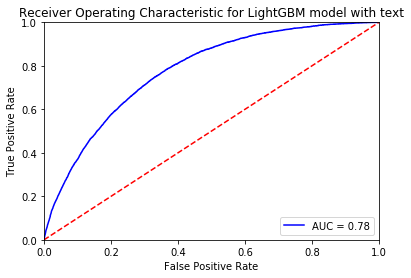

Confusion matrix:
 [[45075 23463]
 [ 1518  4782]]


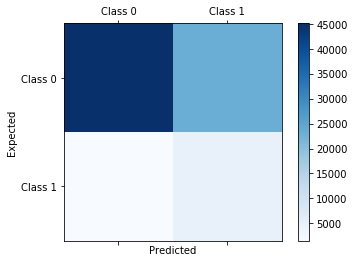

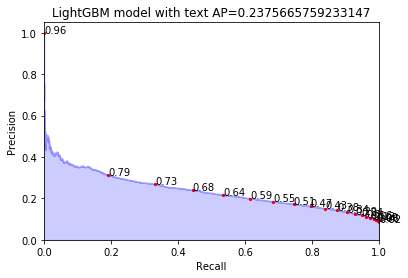

In [51]:
evaluate_model(lgbmodel, X_test, y_test, "LightGBM model with text")

### SHAP values of the new text-enriched model

In [52]:
explainer = shap.TreeExplainer(lgbmodel)
shap_values = explainer.shap_values(X_test)


Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


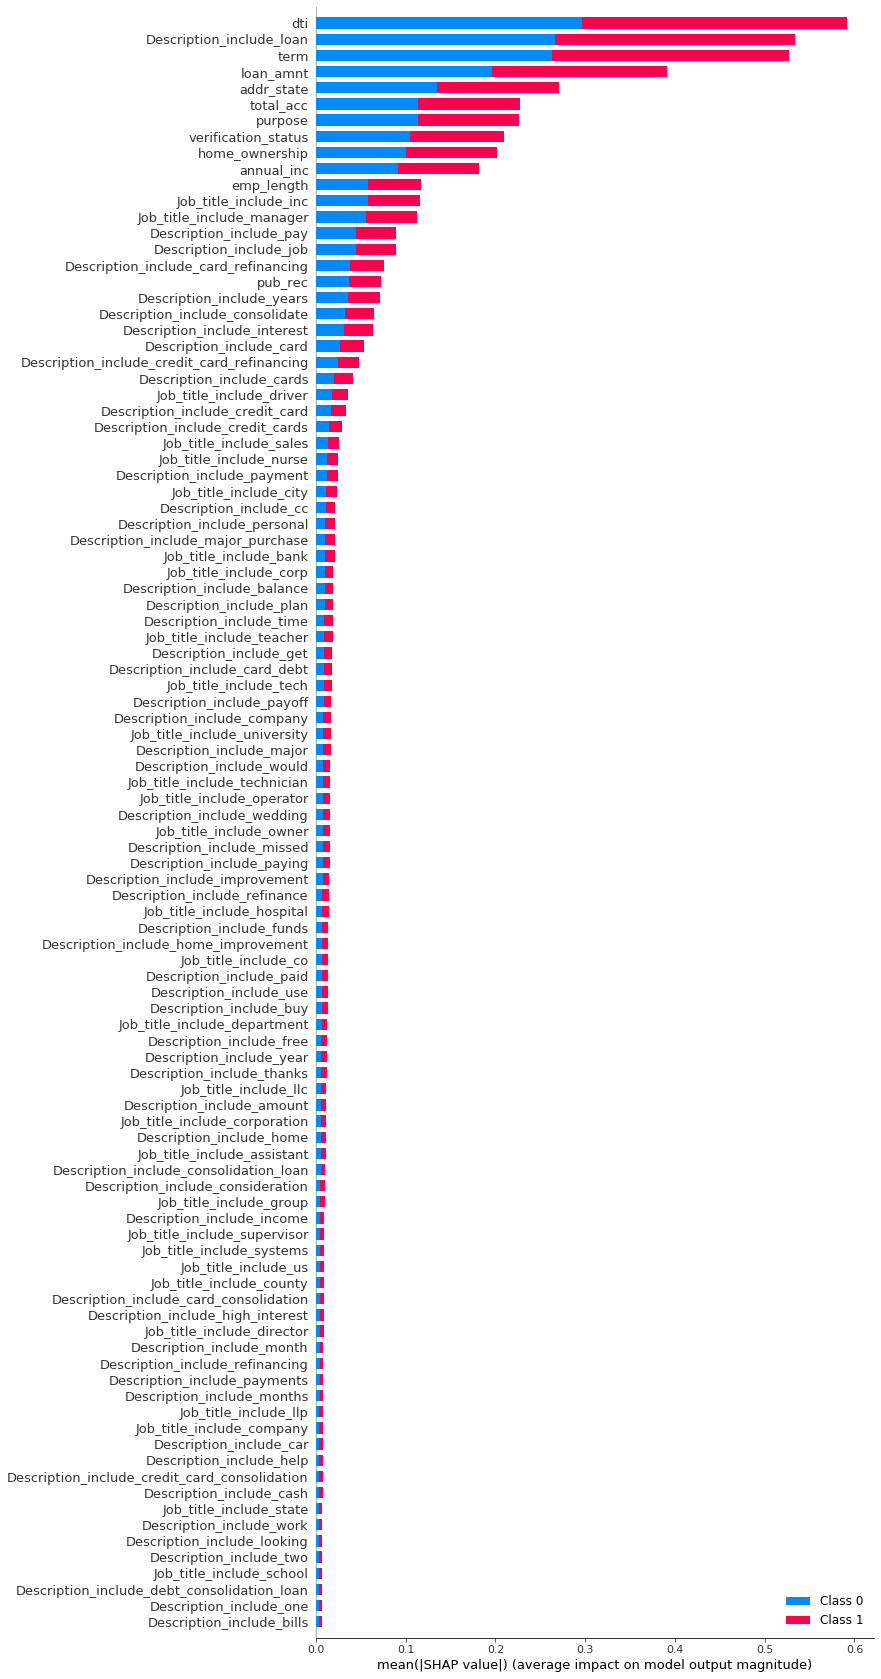

In [53]:
shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(10,30), max_display=100)

In [54]:
scoring_data

,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,desc,purpose,title,addr_state,dti,pub_rec,total_acc,bad_loan
0,3000.0,60 months,University Medical Group,1 year,RENT,80000.0,Source Verified,Borrower added on 12/21/11 > I plan on combi...,other,Personal,OR,17.94,0.0,38.0,NaN
1,7000.0,60 months,Southern Star Photography,8 years,RENT,47004.0,Not Verified,Borrower added on 12/18/11 > I am planning o...,debt_consolidation,Loan,NC,23.51,0.0,11.0,NaN
2,10000.0,60 months,US Legal Support,2 years,RENT,29120.0,Verified,NaN,debt_consolidation,Brown Eyes Loan,FL,22.83,0.0,31.0,NaN
3,12500.0,60 months,United States Infrastructure Corporation,1 year,RENT,27000.0,Verified,Borrower added on 12/20/11 > The purpose of ...,debt_consolidation,Credit card debt,IL,16.04,0.0,24.0,NaN
4,17500.0,60 months,NaN,6 years,RENT,40000.0,Verified,Borrower added on 11/28/11 > Thanks.<br> Bor...,small_business,Start Up,CA,19.47,0.0,6.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601333,10000.0,36 months,Office Assistant,8 years,RENT,31000.0,Verified,NaN,debt_consolidation,Debt consolidation,CA,28.69,1.0,15.0,NaN
601334,24000.0,36 months,Director of Maintenance,10+ years,MORTGAGE,79000.0,Verified,NaN,home_improvement,Home improvement,NJ,3.90,0.0,23.0,NaN
601335,13000.0,60 months,Radiologist Technologist,5 years,RENT,35000.0,Verified,NaN,debt_consolidation,Debt consolidation,TN,30.90,1.0,22.0,NaN
601336,12000.0,60 months,Painter,1 year,RENT,64400.0,Source Verified,NaN,debt_consolidation,Debt consolidation,MA,27.19,0.0,20.0,NaN


### best model setup

    LightGBM
    non-scaled numeric features
    naitively handles categorical features
    TF-representation (limit=200) of Title+desc and emp_title
    recall = 0.76
    precision = 0.19
    AUC = 0.78
    
    


### If this was a real project...

* More Feature engineering
* Hyperparameter tuning 
* cross-validation
* exploring more subsampling techniques
* stacking of models


### But now ... we deploy it! 

In [55]:
scoring_toolbox = {"model":lgbmodel,
                   "categorical_cols": categorical_cols,
                   "numeric_cols": numeric_cols,
                   "text_processing": (tf1, tf2), 
                   "col_order": X_new.columns}

In [56]:
pickle.dump(scoring_toolbox, open("scoring_toolbox.pkl", "wb"))

In [57]:
categorical_cols

5                    term
11             emp_length
12         home_ownership
14    verification_status
16            loan_status
20                purpose
23             addr_state
52       application_type
Name: Column name, dtype: object

### Fetch scoring data

In [59]:
scoring_data = pickle.load(open("scoring_data.pkl", "rb"))
scoring_data["data"].drop("bad_loan", axis=1,inplace=True)

### Define scoring script (can be executed anywhere)

In [60]:
def score_new_data(scoring_data,
                   model_toolbox, 
                   cutoff=0.5):

    scoring_df = scoring_data["data"].copy()


    drop_list=["loan_status", "application_type"]

    categorical_cols=model_toolbox["categorical_cols"]

    categorical_cols_list = [x for x in categorical_cols if x not in drop_list]

    numeric_cols=model_toolbox["numeric_cols"]
    tf1, tf2 = model_toolbox["text_processing"]
    model = model_toolbox["model"]
    col_order=model_toolbox["col_order"]

    scoring_df = fill_nans(scoring_df)

    scoring_df[categorical_cols_list] = clean_categorical_values(scoring_df[categorical_cols_list]).astype("category")

    textfield_1 = scoring_df["desc"] + ' ' + scoring_df["title"]
    textfield_2 = scoring_df["emp_title"]

    textfield_1 = clean_categorical_values(textfield_1, rep=' ', rx='[^a-zA-Z]+')
    textfield_2 = clean_categorical_values(textfield_2, rep=' ', rx='[^a-zA-Z]+')

    df_text1 = tf1.transform(textfield_1, id_str="Description_include_")
    df_text2 = tf2.transform(textfield_2, id_str="Job_title_include_")
    
    X_new = (scoring_df.reset_index(drop=True)
         .merge(df_text1.reset_index(drop=True), 
                left_index=True, right_index=True)
         .merge(df_text2.reset_index(drop=True), 
                left_index=True, right_index=True))
    
    ids = scoring_data['loan_ids']
    return_df = pd.DataFrame()
    return_df["LoanID"]=ids
    return_df["Confidence"] = model.predict(X_new[col_order])
    return_df["Default"] = ["Yes" if x > cutoff else "No" for x in return_df["Confidence"]]
    return return_df


### Score

In [61]:
open_loan_scorings = score_new_data(scoring_data, scoring_toolbox)

print(f"Number of loans scored: {open_loan_scorings.shape[0]}")

'copy' param is unused and has been deprecated since version 0.22. Backward compatibility for 'copy' will be removed in 0.24.


Number of loans scored: 601338


In [62]:
open_loan_scorings.head(20)

,LoanID,Confidence,Default
0,1075358,0.048640,No
1,1069639,0.156544,No
2,1065420,0.672998,Yes
3,1069346,0.367394,No
4,1068934,0.601820,Yes
5,1063958,0.646597,Yes
6,1068575,0.515803,Yes
7,1067874,0.026999,No
8,1034693,0.083883,No
9,1067654,0.355711,No


In [63]:
open_loan_scorings.sort_values(by=["Confidence"], ascending=False).head(20)

,LoanID,Confidence,Default
323783,61343933,0.974354,Yes
379335,58301084,0.973336,Yes
289899,63897970,0.971680,Yes
318940,61933318,0.971178,Yes
75380,35988213,0.969350,Yes
113169,29234284,0.969192,Yes
388306,57783082,0.969113,Yes
576655,38460126,0.968438,Yes
517411,45434911,0.968429,Yes
337172,60774695,0.967919,Yes


### Outline of the project

Data filtering and feature selection

Data visualization

Prepare data for modeling

Modeling
* Linear model etc
* Boosting models

* Adding Text

Define how to put it into production 